# Customer Churn Prediction Project

## Objective
The goal of this project is to build a machine learning model to predict whether a customer will "churn" (leave the service).
We will:
1. Explore and clean the data.
2. Build predictive models.
3. Interpret results using SHAP and feature importance.
4. Provide actionable business insights.

## Dataset
Telco Customer Churn dataset (7,043 customers, 21 features).
Target variable: `Churn` (Yes/No).

!pip install plotly

In [1]:
# Basic libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ML tools
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#time
import time

# Explainability
import shap

# Warnings
import warnings
warnings.filterwarnings('ignore')


## Initial Exploration

In [2]:
df = pd.read_csv("Telco-customer-churn.csv")
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
print("Rows:",df.shape[0],"| Columns:", df.shape[1])

Rows: 7043 | Columns: 21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


<function matplotlib.pyplot.show(close=None, block=None)>

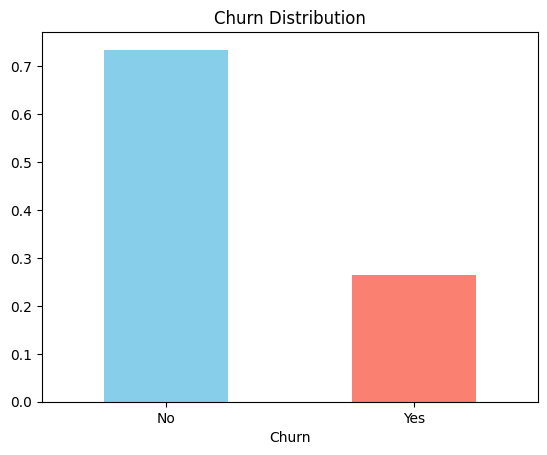

In [6]:
# Target variable distribution
df["Churn"].value_counts(normalize = True).plot(kind = "bar", color =["skyblue", "salmon"])
plt.title("Churn Distribution")
plt.xticks(rotation =360)
plt.show

## Data Cleaning & Handling Null Values

In [7]:
#totalcharge column should be numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = "coerce")
#Senior citizen column is in int64 type - change it to obj
df["SeniorCitizen"] = df["SeniorCitizen"].astype("object")


In [8]:
#handling null values
print (df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [9]:
df["TotalCharges"].fillna( 0 , inplace = True)

## Preprocessing

In [10]:
df.drop("customerID", axis = 1, inplace = True)

In [11]:
# Convert Churn column to binary
df['Churn_numeric'] = df['Churn'].map({'Yes': 1, 'No': 0})
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_numeric
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,1


## Exploring the numerical features

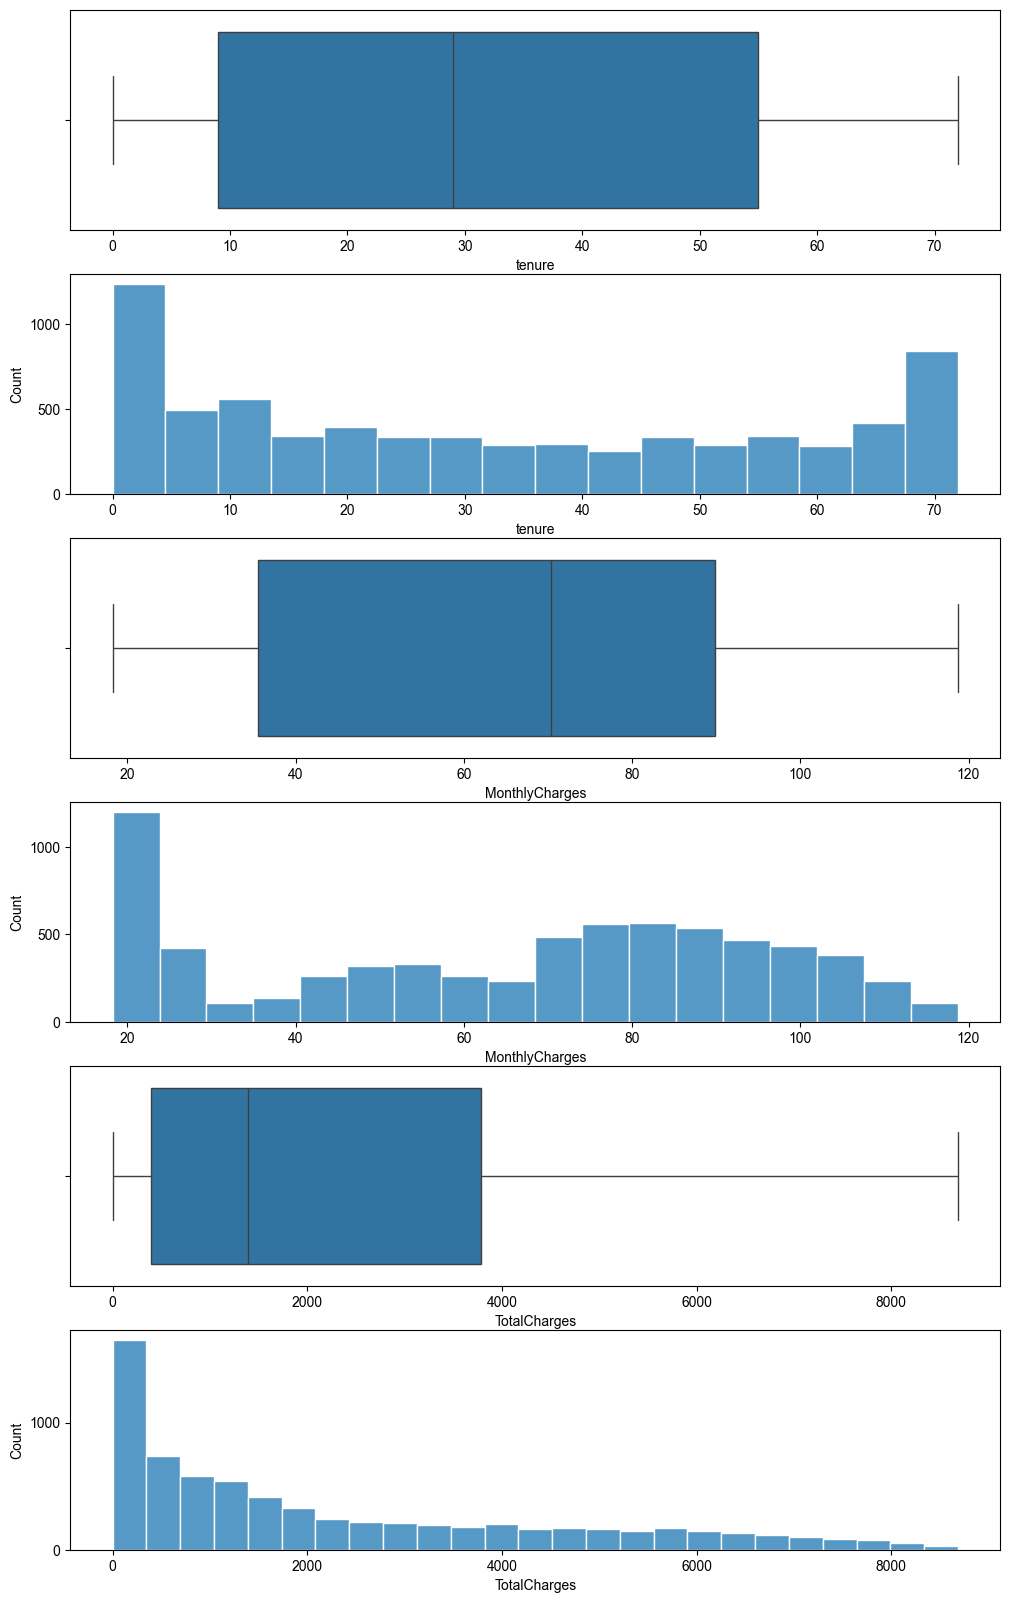

In [12]:
fig, ax = plt.subplots(6, figsize=(12, 20))
sns.set(font_scale=2)

g=sns.boxplot(data=df, x="tenure", ax=ax[0])
g=sns.histplot(data=df, x="tenure", ax=ax[1])


g=sns.boxplot(data=df, x="MonthlyCharges", ax=ax[2])
g=sns.histplot(data=df, x="MonthlyCharges", ax=ax[3])


g=sns.boxplot(data=df, x="TotalCharges", ax=ax[4])
g=sns.histplot(data=df, x="TotalCharges", ax=ax[5])

A large number of customers leave the company within the first 10 months.

There is a small spike of loyal customers who remain with the company for up to 72 months.

Monthly Charges show a right-skewed distribution, with most customers paying between $20 and $25, and fewer customers paying higher amounts.

Total Charges follow a similar pattern — the majority fall within the $0  to $2000 range, with fewer customers exceeding this amount.

Overall, all numerical features in the dataset display a right-skewed distribution.

# Calculating Churn % by Categories

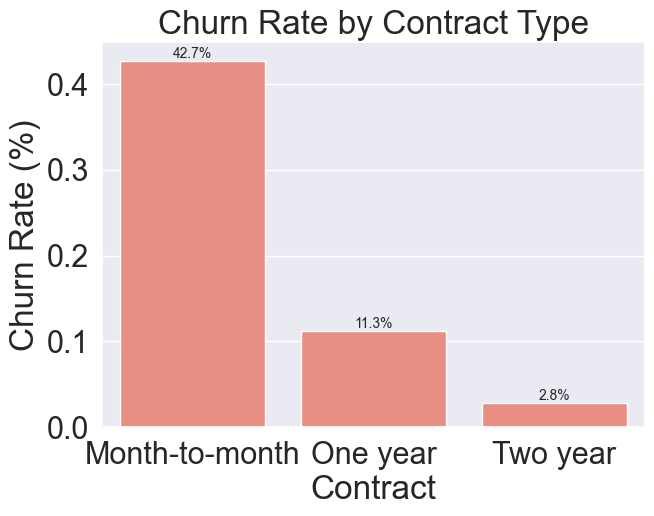

In [13]:
# Calculate churn rate per contract type
contract_churn = df.groupby('Contract')['Churn_numeric'].mean().reset_index()

# Barplot of churn rate
plt.figure(figsize=(7,5))
ax = sns.barplot(data=contract_churn, x='Contract', y='Churn_numeric', color='salmon')

# Add % labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate (%)")
plt.show()

In [14]:
contract_churn 

,Contract,Churn_numeric
0,Month-to-month,0.427097
1,One year,0.112695
2,Two year,0.028319


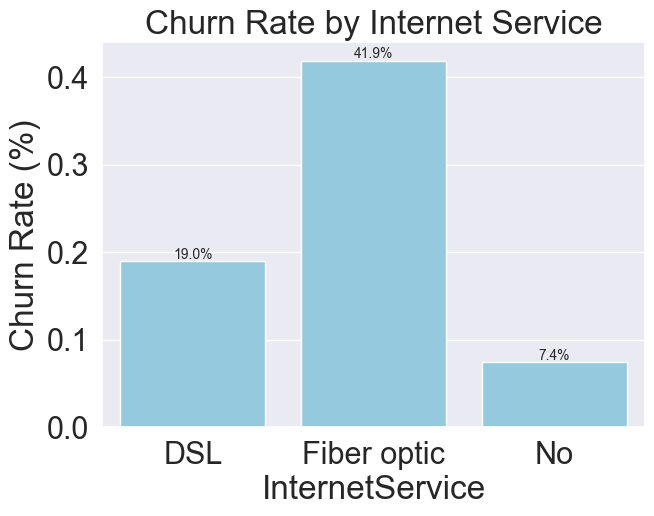

In [15]:
#Churn Rate by Internet Service
internet_churn = df.groupby('InternetService')['Churn_numeric'].mean().reset_index()
plt.figure(figsize=(7,5))
ax = sns.barplot(data=internet_churn, x='InternetService', y='Churn_numeric', color='skyblue')
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.title("Churn Rate by Internet Service")
plt.ylabel("Churn Rate (%)")
plt.show()

In [16]:
#Churn by Payment Method (interactive with Plotly)
fig = px.histogram(df, x="PaymentMethod", color="Churn",
                   barmode="group", title="Churn by Payment Method")
fig.show()

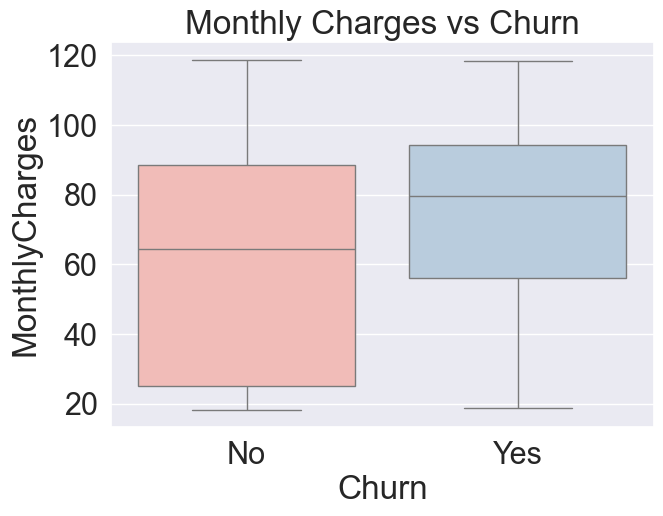

In [17]:
# Boxplot: MonthlyCharges vs Churn
plt.figure(figsize=(7,5))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette="Pastel1")
plt.title("Monthly Charges vs Churn")
plt.show()

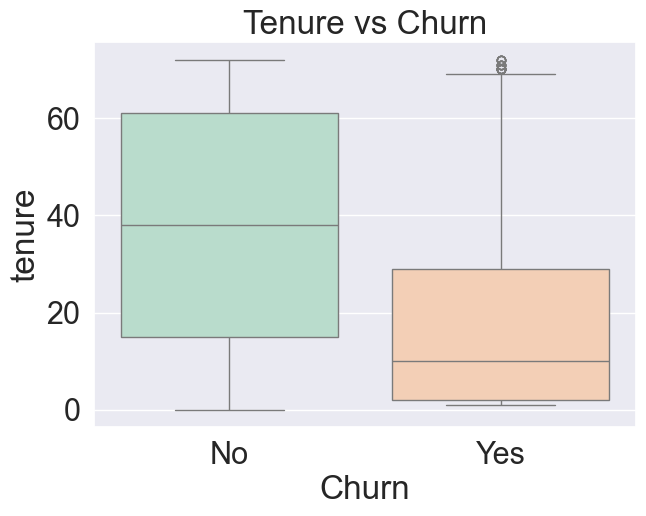

In [18]:
 #Boxplot: Tenure vs Churn
plt.figure(figsize=(7,5))
sns.boxplot(x='Churn', y='tenure', data=df, palette="Pastel2")
plt.title("Tenure vs Churn")
plt.show()

## Investigating Correlations between variables

In [19]:
categorical_variables = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [20]:

#  customer ID is already dropped , drop "churn" too
df_model = df.drop("Churn", axis =1)
# Convert categorical variables to dummies
df_encoded = pd.get_dummies(df_model, columns=categorical_variables, drop_first=True)
df_encoded.head(6)


,tenure,MonthlyCharges,TotalCharges,Churn_numeric,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,34,56.95,1889.50,0,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,2,53.85,108.15,1,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,45,42.30,1840.75,0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,2,70.70,151.65,1,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
5,8,99.65,820.50,1,False,False,False,False,True,False,...,False,True,False,True,False,False,True,False,True,False


In [21]:
# Calculate correlation matrix
corr = df_encoded.corr()

# Get correlation of all features with Churn_numeric
corr_churn = corr['Churn_numeric'].sort_values(ascending=False)

# Display results
print(corr_churn)

Churn_numeric                            1.000000
InternetService_Fiber optic              0.308020
PaymentMethod_Electronic check           0.301919
MonthlyCharges                           0.193356
PaperlessBilling_Yes                     0.191825
SeniorCitizen_1                          0.150889
StreamingTV_Yes                          0.063228
StreamingMovies_Yes                      0.061382
MultipleLines_Yes                        0.040102
PhoneService_Yes                         0.011942
gender_Male                             -0.008612
MultipleLines_No phone service          -0.011942
DeviceProtection_Yes                    -0.066160
OnlineBackup_Yes                        -0.082255
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Partner_Yes                             -0.150448
Dependents_Yes                          -0.164221
TechSupport_Yes                         -0.164674
OnlineSecurity_Yes                      -0.171226


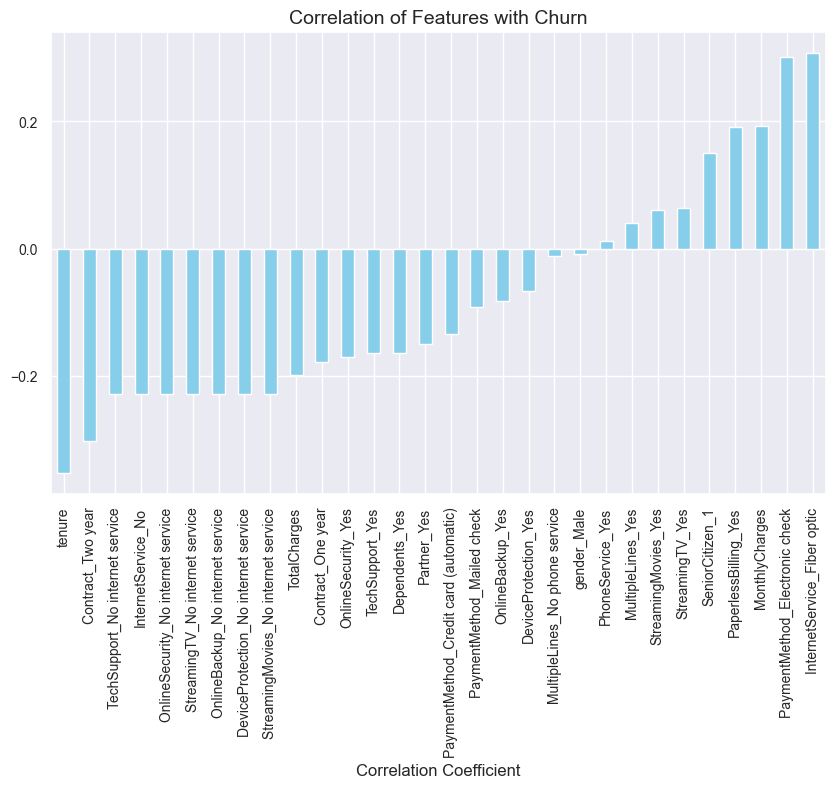

In [22]:
plt.figure(figsize=(10, 6))
corr_churn.drop('Churn_numeric').sort_values().plot(
    kind='bar', 
    color='skyblue', 
    fontsize=10
)
plt.title('Correlation of Features with Churn', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.show()

Tenure has the strongest negative correlation - customers who stay longer are far less likely to churn.

Long-term contracts (One year, Two year) reduce churn - contract-based customers are more loyal.

TechSupport_Yes and OnlineSecurity_Yes lower churn - customers using support or security services tend to stay.

High TotalCharges correlates with low churn - long-term, high-value customers are more stable.

InternetService_Fiber optic has the highest positive correlation - fiber users churn more frequently.

PaymentMethod_Electronic check strongly increases churn - possibly indicating less loyal or price-sensitive customers.

PaperlessBilling_Yes slightly increases churn - these customers may switch providers more easily online.

Higher MonthlyCharges are linked with higher churn - expensive plans lead to dissatisfaction.

SeniorCitizen_1 shows a mild positive correlation - senior customers churn slightly more often.

Gender and PhoneService show almost no correlation - they don’t significantly affect churn behavior.

# Machine Learning Model

In [23]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [24]:
# Define Features (X) and Target (y)
X = df_encoded.drop('Churn_numeric', axis=1)
y = df_encoded['Churn_numeric']

# Define model
model = LogisticRegression(max_iter=1000, solver='liblinear')

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate model using accuracy
scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

print("StratifiedKFold Accuracies:", scores)
print("Average Accuracy:", scores.mean())


StratifiedKFold Accuracies: [0.80979418 0.80837473 0.81618169 0.79190341 0.80113636]
Average Accuracy: 0.8054780751984


In [25]:
# Repeated Stratified K-Fold (5 folds × 3 repeats = 15 evaluations)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# Cross-validation
scores = cross_val_score(model, X, y, cv=rskf, scoring='accuracy')

print("Repeated StratifiedKFold Accuracies:", scores)
print("Average Accuracy:", scores.mean())


Repeated StratifiedKFold Accuracies: [0.80979418 0.80837473 0.81618169 0.79190341 0.80113636 0.81192335
 0.80908446 0.78708304 0.81107955 0.79545455 0.80411639 0.8012775
 0.80908446 0.79900568 0.80539773]
Average Accuracy: 0.8040598049336514


In [27]:
#Fit model on training data
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (5634, 30)
Test set shape: (1409, 30)


In [28]:
# Fit logistic regression model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probability of churn (1)


In [29]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix
)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Accuracy: 0.8026969481902059
Precision: 0.6528662420382165
Recall: 0.5481283422459893
F1 Score: 0.5959302325581395
ROC-AUC: 0.8422976568756619

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409


Confusion Matrix:
 [[926 109]
 [169 205]]


## interpretation

Accuracy (80%) → The model correctly predicts about 8 out of 10 customer churn outcomes.

Precision (65%) → Out of all customers predicted as churners, 65% actually churned.
(Good precision means fewer false churn alerts.)

Recall (55%) → The model identifies 55% of actual churners.
(Moderate recall means some churners are still missed.)

F1 Score (0.59) → Balanced measure of precision and recall. Shows moderate performance.

ROC-AUC (0.84) → Excellent overall ability to distinguish churners from non-churners.

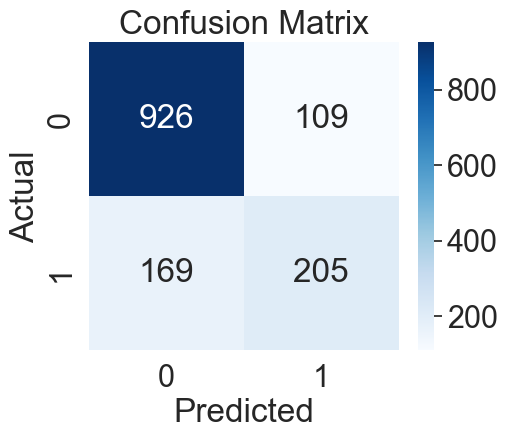

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



Top Positive Influences on Churn:
                           Feature  Coefficient
10     InternetService_Fiber optic     0.672540
26            PaperlessBilling_Yes     0.402604
9                MultipleLines_Yes     0.274143
28  PaymentMethod_Electronic check     0.255529
8   MultipleLines_No phone service     0.237326
23             StreamingMovies_Yes     0.195134
21                 StreamingTV_Yes     0.189178
4                  SeniorCitizen_1     0.160259
5                      Partner_Yes     0.050067
29      PaymentMethod_Mailed check     0.040724

Top Negative Influences on Churn:
                                Feature  Coefficient
18      TechSupport_No internet service    -0.114282
22  StreamingMovies_No internet service    -0.114282
20      StreamingTV_No internet service    -0.114282
15                     OnlineBackup_Yes    -0.219875
6                        Dependents_Yes    -0.229021
7                      PhoneService_Yes    -0.493676
19                      TechSup

<Figure size 800x600 with 0 Axes>

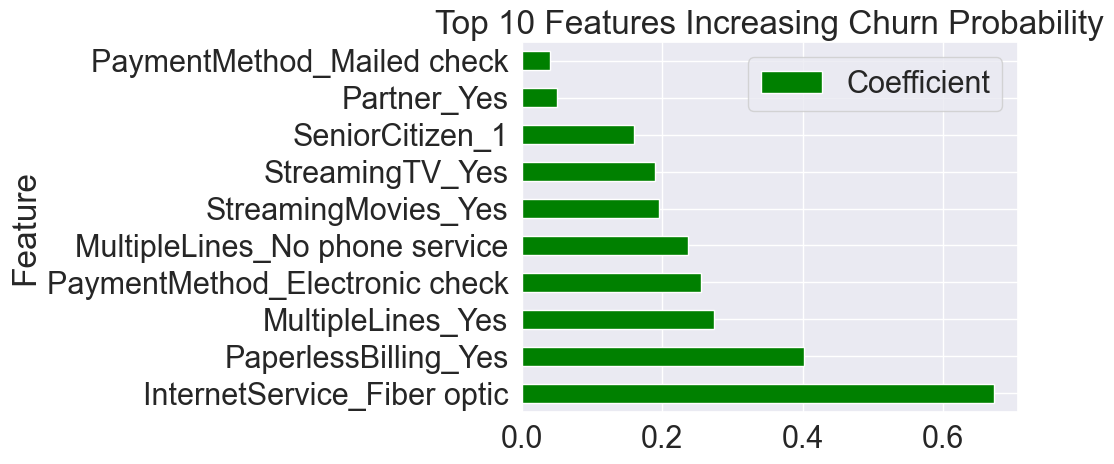

In [31]:
# Create a DataFrame of features and their coefficients
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

# Sort by importance
importance = importance.sort_values(by='Coefficient', ascending=False)

# Display top 10 features
print("\nTop Positive Influences on Churn:")
print(importance.head(10))

print("\nTop Negative Influences on Churn:")
print(importance.tail(10))

# Visualize
plt.figure(figsize=(8,6))
importance.head(10).plot(kind='barh', x='Feature', y='Coefficient', color='green')
plt.title('Top 10 Features Increasing Churn Probability')
plt.show()


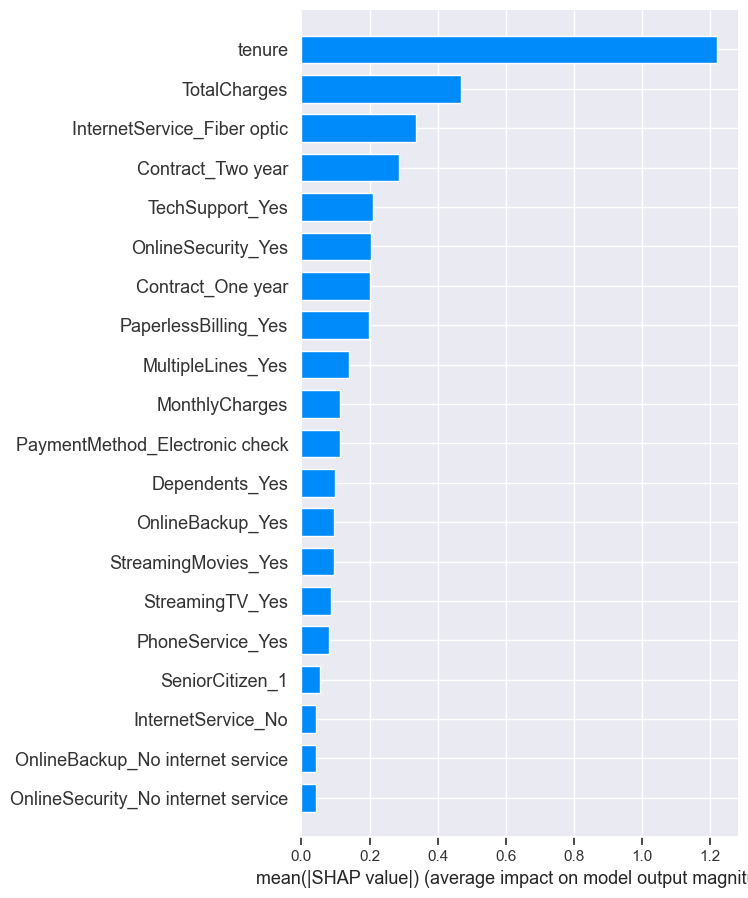

In [37]:
import shap

# Create masker (handles independent features)
masker = shap.maskers.Independent(X_train)

# Create SHAP explainer for Logistic Regression model
explainer = shap.LinearExplainer(model, masker=masker)

# Compute SHAP values
shap_values = explainer(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values.values, X_test, plot_type="bar")